In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.metrics import  mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler


from deepctr.feature_column import SparseFeat, DenseFeat, VarLenSparseFeat, get_feature_names
from deepctr.models import DeepFM

In [2]:
data = pd.read_csv("../data/recipe/merged_data.csv")

In [3]:
data.head(3)

,user_id,recipe_id,rating,name,minutes,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
0,38094,40893,4,white bean green chile pepper soup,495,"['weeknight', 'time-to-make', 'course', 'main-...","[204.8, 5.0, 9.0, 26.0, 24.0, 2.0, 10.0]",4,"['combine beans , onion , chilies , 1 / 2 teas...",easy soup for the crockpot.,"['great northern beans', 'yellow onion', 'dice...",9
1,1293707,40893,5,white bean green chile pepper soup,495,"['weeknight', 'time-to-make', 'course', 'main-...","[204.8, 5.0, 9.0, 26.0, 24.0, 2.0, 10.0]",4,"['combine beans , onion , chilies , 1 / 2 teas...",easy soup for the crockpot.,"['great northern beans', 'yellow onion', 'dice...",9
2,8937,44394,4,devilicious cookie cake delights,20,"['30-minutes-or-less', 'time-to-make', 'course...","[132.3, 11.0, 39.0, 5.0, 4.0, 11.0, 5.0]",5,"['blend together cake mix , oil and eggs', 'ad...",NaN,"[""devil's food cake mix"", 'vegetable oil', 'eg...",4


In [4]:
data = data[data['rating'] != 0]

In [5]:
data.dropna(inplace=True)

In [6]:
data.drop(['steps', 'description'], axis=1, inplace=True)

In [8]:
data.shape

(1049154, 10)

In [9]:
# Get unique recipe IDs
recipe_ids = data['recipe_id'].unique()

# Define the percentage of recipes to remove
percentage_to_remove = 0.7

# Calculate the number of recipes to remove
num_recipes_to_remove = int(len(recipe_ids) * percentage_to_remove)

# Randomly select recipes to remove
recipes_to_remove = np.random.choice(recipe_ids, num_recipes_to_remove, replace=False)

# Remove rows with selected recipe IDs
data = data[~data['recipe_id'].isin(recipes_to_remove)]

In [10]:
data.shape

(313613, 10)

In [11]:
data.head(3)

,user_id,recipe_id,rating,name,minutes,tags,nutrition,n_steps,ingredients,n_ingredients
30,483827,306785,5,spicy nectarine and corn salsa,40,"['60-minutes-or-less', 'time-to-make', 'course...","[95.3, 1.0, 50.0, 16.0, 5.0, 0.0, 7.0]",4,"['nectarines', 'ear of corn', 'shallot', 'haba...",8
35,6258,20930,5,2 tomato pasta salad,30,"['30-minutes-or-less', 'time-to-make', 'course...","[549.0, 40.0, 41.0, 20.0, 38.0, 34.0, 20.0]",8,"['pasta', 'bacon', 'red peppers', 'sun-dried t...",15
36,102602,20930,5,2 tomato pasta salad,30,"['30-minutes-or-less', 'time-to-make', 'course...","[549.0, 40.0, 41.0, 20.0, 38.0, 34.0, 20.0]",8,"['pasta', 'bacon', 'red peppers', 'sun-dried t...",15


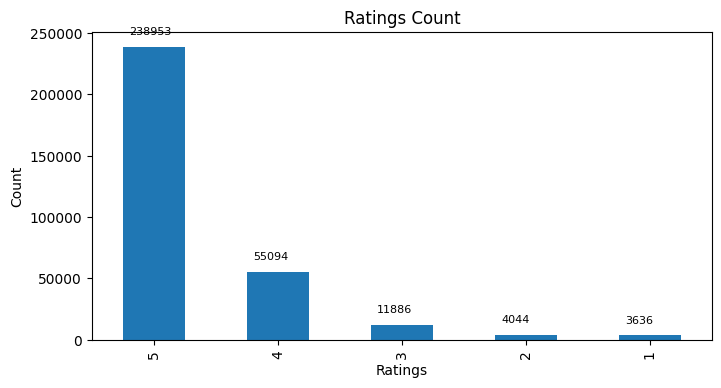

In [30]:
ax = data['rating'].value_counts().plot(kind='bar', figsize=(8, 4))
plt.title("Ratings Count")
plt.xlabel("Ratings")
plt.ylabel("Count")

# Add rating count on top of each bar
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + 0.05, p.get_height() + 10000), fontsize=8)

In [12]:
sparse_features = ['user_id', 'recipe_id']
dense_features = ['minutes', 'n_steps', 'n_ingredients']
varlen_features = ['tags', 'nutrition', 'ingredients']

In [13]:
data[sparse_features] = data[sparse_features].astype(str)

In [14]:
# Do simple Transformation for dense features
mms = MinMaxScaler(feature_range=(0, 1))
data[dense_features] = mms.fit_transform(data[dense_features])

In [15]:
def pad_varlen(varlen_list, max_len=None):
    if not max_len:
        length = np.array([len(item) for item in varlen_list]) 
        max_len = max(length)
    return (max_len, pad_sequences(varlen_list, maxlen=max_len, padding='post', dtype=object, value=0).astype(str))

In [16]:
import ast

def convert_to_list(string):
    return ast.literal_eval(string)

for feature in varlen_features:
    data[feature] = data[feature].apply(convert_to_list)

In [17]:
train, test = train_test_split(data, test_size=0.2)

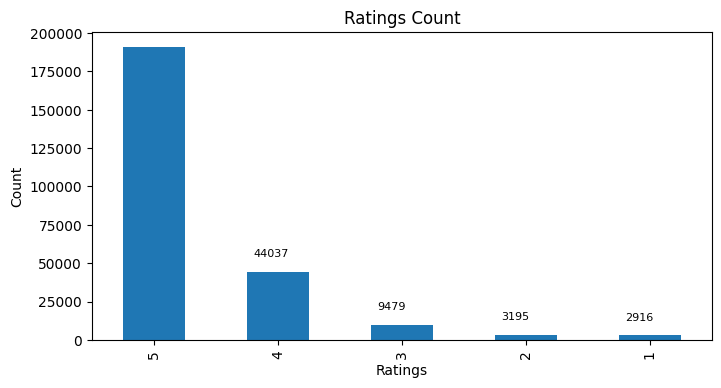

In [31]:
ax = train['rating'].value_counts().plot(kind='bar', figsize=(8, 4))
plt.title("Ratings Count")
plt.xlabel("Ratings")
plt.ylabel("Count")

# Add rating count on top of each bar
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + 0.05, p.get_height() + 10000), fontsize=8)

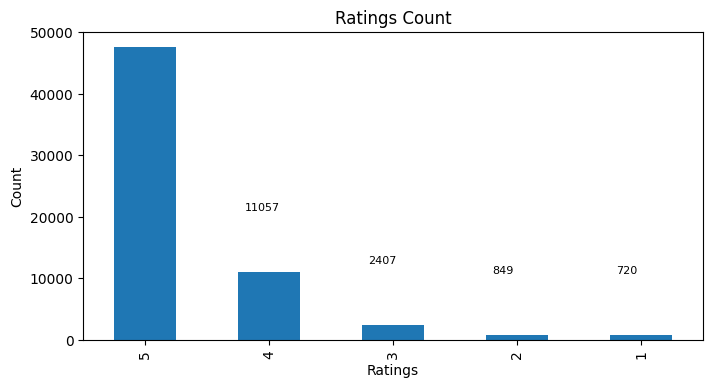

In [33]:
ax = test['rating'].value_counts().plot(kind='bar', figsize=(8, 4))
plt.title("Ratings Count")
plt.xlabel("Ratings")
plt.ylabel("Count")

# Add rating count on top of each bar
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + 0.05, p.get_height() + 10000), fontsize=8)

In [18]:
(tm, tags_train) = pad_varlen(train['tags'])
(nm, nutrition_train) = pad_varlen(train['nutrition'])
(im, ingredients_train) = pad_varlen(train['ingredients'])

In [19]:
(_, tags_test) = pad_varlen(test['tags'], tm)
(_, nutrition_test) = pad_varlen(test['nutrition'], nm)
(_, ingredients_test) = pad_varlen(test['ingredients'], im)

In [20]:
max_length = [tm, nm, im]

In [21]:
# Set hashing space for each sparse field and generate feature config for sequence feature
fixlen_feature_columns = [SparseFeat(feat, data[feat].nunique() * 5, embedding_dim=4, use_hash=True, dtype='string')
                            for feat in sparse_features]

dense_feature_columns = [DenseFeat(feat, 1, ) for feat in dense_features]

varlen_feature_columns = [
    VarLenSparseFeat(SparseFeat(feat, vocabulary_size=100, embedding_dim=4, use_hash=True, dtype="string"),
                        maxlen=max_len, combiner='mean', )
                        for max_len, feat in zip(max_length, varlen_features)]

linear_feature_columns = fixlen_feature_columns + dense_feature_columns + varlen_feature_columns
dnn_feature_columns = fixlen_feature_columns + dense_feature_columns + varlen_feature_columns
feature_names = get_feature_names(linear_feature_columns + dnn_feature_columns)

In [22]:
feature_names

['user_id',
 'recipe_id',
 'minutes',
 'n_steps',
 'n_ingredients',
 'tags',
 'nutrition',
 'ingredients']

In [23]:
# Generate input data for model
train_model_input = {name: train[name] for name in feature_names}
test_model_input = {name: test[name] for name in feature_names}

train_model_input['tags'] = tags_train
train_model_input['nutrition'] = nutrition_train
train_model_input['ingredients'] = ingredients_train

In [24]:
test_model_input['tags'] = tags_test
test_model_input['nutrition'] = nutrition_test
test_model_input['ingredients'] = ingredients_test

In [25]:
# Define Model,compile and train
model = DeepFM(linear_feature_columns, dnn_feature_columns, task='regression')

model.compile("adam", "mse", metrics=['mse'], )
history = model.fit(train_model_input, train['rating'].values,
                    batch_size=256, epochs=10, verbose=2, validation_split=0.2, )

Epoch 1/10
785/785 - 120s - loss: 1.0039 - mse: 1.0031 - val_loss: 0.4787 - val_mse: 0.4767
Epoch 2/10
785/785 - 113s - loss: 0.3602 - mse: 0.3570 - val_loss: 0.4993 - val_mse: 0.4949
Epoch 3/10
785/785 - 116s - loss: 0.2596 - mse: 0.2545 - val_loss: 0.5774 - val_mse: 0.5713
Epoch 4/10
785/785 - 112s - loss: 0.2094 - mse: 0.2028 - val_loss: 0.5524 - val_mse: 0.5450
Epoch 5/10
785/785 - 112s - loss: 0.1779 - mse: 0.1703 - val_loss: 0.6364 - val_mse: 0.6282
Epoch 6/10
785/785 - 121s - loss: 0.1585 - mse: 0.1500 - val_loss: 0.5978 - val_mse: 0.5889
Epoch 7/10
785/785 - 116s - loss: 0.1452 - mse: 0.1362 - val_loss: 0.6377 - val_mse: 0.6284
Epoch 8/10
785/785 - 111s - loss: 0.1346 - mse: 0.1252 - val_loss: 0.6304 - val_mse: 0.6206
Epoch 9/10
785/785 - 117s - loss: 0.1265 - mse: 0.1167 - val_loss: 0.6428 - val_mse: 0.6327
Epoch 10/10
785/785 - 109s - loss: 0.1194 - mse: 0.1092 - val_loss: 0.6399 - val_mse: 0.6295


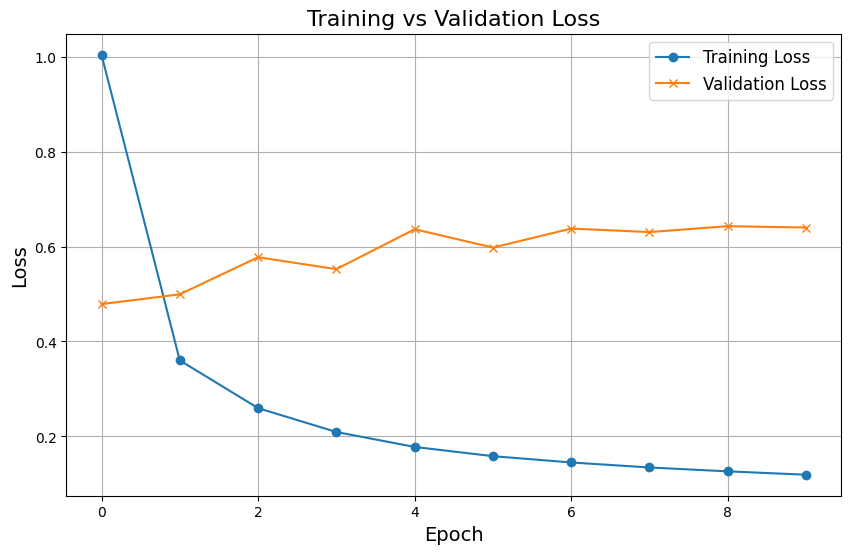

In [26]:
import matplotlib.pyplot as plt

train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Training Loss', marker='o')
plt.plot(val_loss, label='Validation Loss', marker='x')

plt.title("Training vs Validation Loss", fontsize=16)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)

plt.show()

In [34]:
# Change vocabulary size
fixlen_feature_columns = [SparseFeat(feat, data[feat].nunique() * 5, embedding_dim=4, use_hash=True, dtype='string')
                            for feat in sparse_features]

dense_feature_columns = [DenseFeat(feat, 1, ) for feat in dense_features]

varlen_feature_columns = [
    VarLenSparseFeat(SparseFeat(feat, vocabulary_size=1000, embedding_dim=4, use_hash=True, dtype="string"),
                        maxlen=max_len, combiner='mean', )
                        for max_len, feat in zip(max_length, varlen_features)]

linear_feature_columns = fixlen_feature_columns + dense_feature_columns + varlen_feature_columns
dnn_feature_columns = fixlen_feature_columns + dense_feature_columns + varlen_feature_columns
feature_names = get_feature_names(linear_feature_columns + dnn_feature_columns)

# Generate input data for model
train_model_input = {name: train[name] for name in feature_names}
test_model_input = {name: test[name] for name in feature_names}

train_model_input['tags'] = tags_train
train_model_input['nutrition'] = nutrition_train
train_model_input['ingredients'] = ingredients_train

test_model_input['tags'] = tags_test
test_model_input['nutrition'] = nutrition_test
test_model_input['ingredients'] = ingredients_test

In [35]:
# Define Model,compile and train
model = DeepFM(linear_feature_columns, dnn_feature_columns, task='regression')

model.compile("adam", "mse", metrics=['mse'], )
history = model.fit(train_model_input, train['rating'].values,
                    batch_size=256, epochs=10, verbose=2, validation_split=0.2, )

Epoch 1/10
785/785 - 118s - loss: 1.1328 - mse: 1.1319 - val_loss: 0.4800 - val_mse: 0.4779
Epoch 2/10
785/785 - 109s - loss: 0.3648 - mse: 0.3614 - val_loss: 0.5032 - val_mse: 0.4986
Epoch 3/10
785/785 - 112s - loss: 0.2606 - mse: 0.2553 - val_loss: 0.5812 - val_mse: 0.5749
Epoch 4/10
785/785 - 111s - loss: 0.2107 - mse: 0.2039 - val_loss: 0.6795 - val_mse: 0.6721
Epoch 5/10
785/785 - 114s - loss: 0.1838 - mse: 0.1761 - val_loss: 0.5826 - val_mse: 0.5743
Epoch 6/10
785/785 - 115s - loss: 0.1632 - mse: 0.1548 - val_loss: 0.6056 - val_mse: 0.5967
Epoch 7/10
785/785 - 115s - loss: 0.1481 - mse: 0.1390 - val_loss: 0.6949 - val_mse: 0.6855
Epoch 8/10
785/785 - 115s - loss: 0.1400 - mse: 0.1305 - val_loss: 0.6463 - val_mse: 0.6364
Epoch 9/10
785/785 - 116s - loss: 0.1303 - mse: 0.1203 - val_loss: 0.6159 - val_mse: 0.6056
Epoch 10/10
785/785 - 126s - loss: 0.1239 - mse: 0.1135 - val_loss: 0.6367 - val_mse: 0.6261


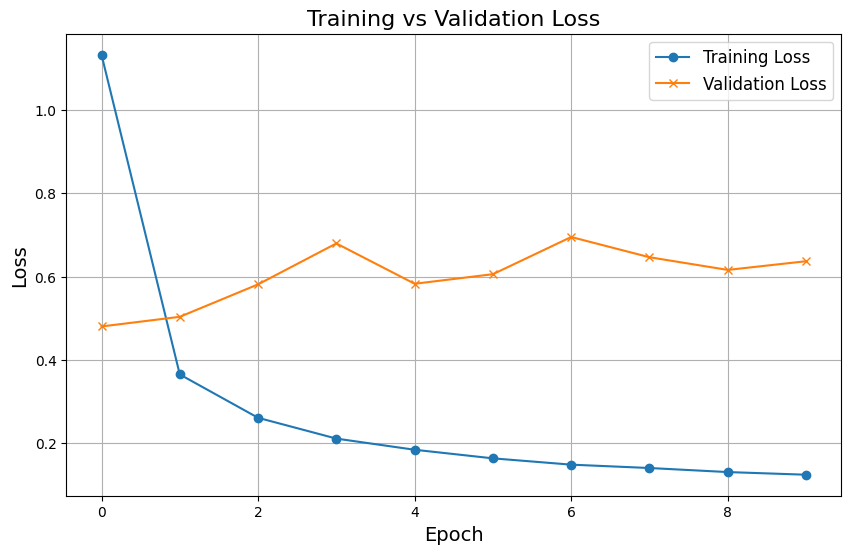

In [36]:
import matplotlib.pyplot as plt

train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Training Loss', marker='o')
plt.plot(val_loss, label='Validation Loss', marker='x')

plt.title("Training vs Validation Loss", fontsize=16)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)

plt.show()

In [37]:
# Predict
pred_ans = model.predict(test_model_input, batch_size=256)

# Evaluate Model
mse_value = mean_squared_error(test['rating'].values, pred_ans)
print("Test MSE:", round(mse_value, 4))

Test MSE: 0.6327


### Self Evaluation

In [38]:
ground_truth = test['rating'].values
prediction = pred_ans
type(ground_truth), type(prediction)

(numpy.ndarray, numpy.ndarray)

In [44]:
indices = np.random.choice(10000, size=10, replace=False)
sample_array1 = ground_truth[indices]
sample_array2 = prediction[indices]

In [45]:
df = pd.DataFrame({'truth': sample_array1.flatten(), 'pred': sample_array2.flatten()})
df['diff'] = np.abs(df['truth'] - df['pred'])
df

,truth,pred,diff
0,3,4.925328,1.925328
1,5,5.059165,0.059165
2,5,4.825231,0.174769
3,4,4.114690,0.114690
4,5,4.958176,0.041824
5,5,5.119125,0.119125
6,5,5.094689,0.094689
7,4,5.131156,1.131156
8,3,4.063323,1.063323
9,5,4.625883,0.374117
